In [1]:
# importações necessárias para o algoritmo
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
from numpy import concatenate

from matplotlib import pyplot
from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# transforma a data em formato apropriado
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

In [3]:
# carrega os dados do conjunto de dados de entrada, padroniza e os salva no local desejado
def format_dataset(input_path, output_path):
    dataset = read_csv(input_path,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
    dataset.drop('No', axis=1, inplace=True)

    # dá nomes específicos para as colunas
    dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
    dataset.index.name = 'date'

    # substitue todos os valores NA por 0
    dataset['pollution'].fillna(0, inplace=True)

    # exclui as primeiras 24 horas do dataset
    dataset = dataset[24:]

    # mostra apenas as primeiras 5 linhas
    print(dataset.head())

    # salva em arquivo
    dataset.to_csv(output_path)

format_dataset('../data/raw.csv', '../data/pollution.csv')

In [66]:
# carrega o conjunto de dados
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset('../data/pollution.csv')
values = dataset.values

['SE' 'SE' 'SE' ... 'NW' 'NW' 'NW']


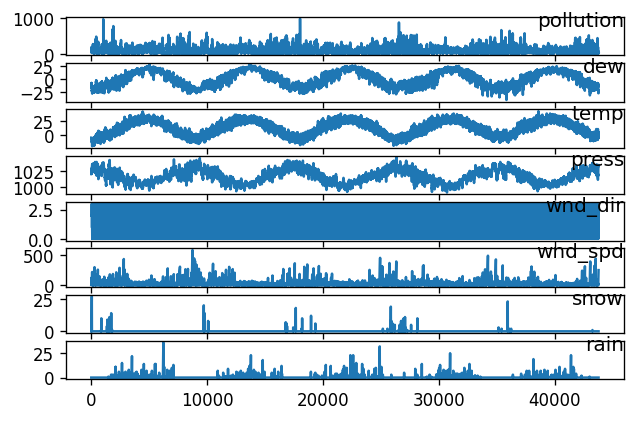

[2. 2. 2. ... 1. 1. 1.]


In [65]:
# plota cada coluna como um gráfico
def plot_columns(values):
    groups = range(0,len(values[0]))
    i = 1
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.5, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [149]:
# converte as series para aprendizagem supervisionada
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# codifica os rotulos da coluna 4 em inteiros
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# muda o tipo dos valores para ponto flutuante
values = values.astype('float32')

# normaliza a escala dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled)

# remove as colunas que não queremos predizer
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var8(t),var9(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.0,0.159960
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.0,0.182093
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.0,0.138833
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.0,0.109658
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.0,0.105634


In [147]:
# separa o conjunto de dados em subconjuntos de treino e teste
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# separa os subconjuntos de treino e teste em outros subconjuntos
# de entradas e saídas esperadas
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# configura a entrada para ser 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.0581 - val_loss: 0.0539
Epoch 2/50
 - 0s - loss: 0.0409 - val_loss: 0.0573
Epoch 3/50
 - 0s - loss: 0.0256 - val_loss: 0.0504
Epoch 4/50
 - 0s - loss: 0.0190 - val_loss: 0.0451
Epoch 5/50
 - 0s - loss: 0.0169 - val_loss: 0.0341
Epoch 6/50
 - 0s - loss: 0.0157 - val_loss: 0.0245
Epoch 7/50
 - 0s - loss: 0.0150 - val_loss: 0.0181
Epoch 8/50
 - 0s - loss: 0.0149 - val_loss: 0.0171
Epoch 9/50
 - 0s - loss: 0.0147 - val_loss: 0.0161
Epoch 10/50
 - 0s - loss: 0.0147 - val_loss: 0.0153
Epoch 11/50
 - 0s - loss: 0.0146 - val_loss: 0.0150
Epoch 12/50
 - 0s - loss: 0.0146 - val_loss: 0.0148
Epoch 13/50
 - 0s - loss: 0.0146 - val_loss: 0.0147
Epoch 14/50
 - 0s - loss: 0.0146 - val_loss: 0.0145
Epoch 15/50
 - 0s - loss: 0.0146 - val_loss: 0.0142
Epoch 16/50
 - 0s - loss: 0.0146 - val_loss: 0.0140
Epoch 17/50
 - 0s - loss: 0.0145 - val_loss: 0.0140
Epoch 18/50
 - 0s - loss: 0.0145 - val_loss: 0.0141
Epoch 19/50
 - 0s - loss

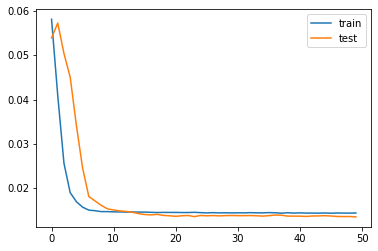

In [132]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=True)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)